In [1]:
%matplotlib inline
import sys, os
sys.path.append("../")
import numpy as np
import scipy as sp
import numpy.linalg as nla
import matplotlib as mpl
import matplotlib.pyplot as plt
from timeit import timeit
import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss
from drot.solver import drot
from drot.proximal import *
import csv
%load_ext autoreload
%autoreload 2

# Optimal transport

In [2]:
def save(C, nrows, ncols, filename):
    assert C.flags['F_CONTIGUOUS']   
    output_file = open(filename, 'wb')
    C.tofile(output_file)
    output_file.close()

def one_dimensional_gaussian_ot(n):
    t = np.arange(0, n)/n
    Gaussian = lambda t0, sigma: np.exp(-(t-t0)**2 / (2*sigma**2))
    normalize = lambda p: p / np.sum(p)
    sigma = 0.1;
    p = Gaussian(.75, sigma)
    q = Gaussian(.15, sigma)
    vmin = .02;
    p = normalize(p + np.max(p) * vmin)
    q = normalize(q + np.max(q) * vmin)
    [Y,X] = np.meshgrid(t,t)
    C = np.array((X-Y)**2, order='F')
    return n, C, p, q

def two_dimensional_gaussian_ot(m, n):
    mu_s = np.array([0, 0.5])
    cov_s = np.array([[1, 0.5], [0.5, 1]])
    mu_t = np.array([4, 10])
    cov_t = np.array([[0.85, 0.1], [0.1, 0.85]])
    xs = ot.datasets.make_2D_samples_gauss(m, mu_s, cov_s)
    xt = ot.datasets.make_2D_samples_gauss(n, mu_t, cov_t)
    p, q = np.ones((m,)) / m, np.ones((n,)) / n  
    C = np.array(ot.dist(xs, xt), order='F')
    C /= C.max()
    return m, n, C, p, q


In [9]:
def multi_experiment(m, n, max_iters, accuracies, skregs, alpha=1.0, ntests=20, verbskip=1):
    num_accuracies = accuracies.shape[0]
    num_algs = skregs.shape[0] + 1
    outs = np.zeros([num_algs, 1, num_accuracies, ntests])
    
    for test_idx in range(ntests):
        print("\n *** Experiment", test_idx+1, "of", ntests, "***")
        m, n, C, p, q = two_dimensional_gaussian_ot(m, n)
        x0 = np.array(np.outer(p, q), order = 'F')
        step = alpha / (m+n)
        
        C_ = C.copy()
        G0 = ot.emd(p, q, C_, numItermax=1_000_000)
        optval = np.sum(G0 * C_)

        drout = drot(x0, C, p, q, max_iters=max_iters, step=step, compute_r_primal=True, 
                        compute_r_dual=False, adapt_stepsize=False, eps_abs=1e-4, eps_rel=0.0)
        
        skout = []                        
        for reg in skregs:
            skout.append(ot.sinkhorn(p, q, C_, reg, numItermax=1000, stopThr=7e-5))
        
        outs[0, 0, :, test_idx] = abs(np.sum(drout['sol']*C) - optval) / optval
        for sk_idx in range(skregs.shape[0]):
           outs[sk_idx+1, 0, :, test_idx] = abs(np.sum(skout[sk_idx]*C_) - optval) / optval

    file_name = 'Dims_' + str(m) + '_test_' + str(ntests)
    np.save('output/'+file_name + '.npy', outs)
    return file_name

def profile(dir, accuracies, labels, colors):     
    outs = np.load(dir)
    (num_algs, num_objs_computed, num_accuracies, ntests) = outs.shape
    performance_ratio = np.zeros((num_algs, num_accuracies))
    
    for alg_idx in range(num_algs):
        for acc_idx in range(num_accuracies):
            performance_ratio[alg_idx, acc_idx] = np.sum((outs[alg_idx, 0, acc_idx, :] <= accuracies[acc_idx])) / ntests

    fig = plt.figure()        
    for alg_idx in range(num_algs):
        plt.plot(accuracies, performance_ratio[alg_idx, :], color=colors[alg_idx], label=labels[alg_idx], linewidth=2.5)
  
    ylabel = r'Performance ratio'
    plt.xlabel(r'Final accuracy')
    plt.ylabel(ylabel)
    plt.xscale('log')
    plt.legend()
        
    return fig

In [14]:
m, n = 500, 500
max_iters = 1000
accuracies = np.logspace(-4.5, -1, num=15)
skregs = np.array([1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1])

file_name = multi_experiment(m, n, max_iters, accuracies, skregs, alpha=2, ntests=50)


 *** Experiment 1 of 50 ***
Drot terminated at iteration  945

 *** Experiment 2 of 50 ***


/Users/vienmai/miniconda3/envs/common/lib/python3.8/site-packages/ot/bregman.py:363: RuntimeWarning: divide by zero encountered in true_divide
  v = np.divide(b, KtransposeU)
/Users/vienmai/miniconda3/envs/common/lib/python3.8/site-packages/ot/bregman.py:363: RuntimeWarning: overflow encountered in true_divide
  v = np.divide(b, KtransposeU)


Drot terminated at iteration  999

 *** Experiment 3 of 50 ***
Drot terminated at iteration  879

 *** Experiment 4 of 50 ***
Drot terminated at iteration  999

 *** Experiment 5 of 50 ***
Drot terminated at iteration  974

 *** Experiment 6 of 50 ***
Drot terminated at iteration  962

 *** Experiment 7 of 50 ***
Drot terminated at iteration  999

 *** Experiment 8 of 50 ***
Drot terminated at iteration  815

 *** Experiment 9 of 50 ***
Drot terminated at iteration  939

 *** Experiment 10 of 50 ***
Drot terminated at iteration  952

 *** Experiment 11 of 50 ***
Drot terminated at iteration  880

 *** Experiment 12 of 50 ***
Drot terminated at iteration  999

 *** Experiment 13 of 50 ***
Drot terminated at iteration  882

 *** Experiment 14 of 50 ***
Drot terminated at iteration  916

 *** Experiment 15 of 50 ***
Drot terminated at iteration  882

 *** Experiment 16 of 50 ***
Drot terminated at iteration  943

 *** Experiment 17 of 50 ***
Drot terminated at iteration  895

 *** Experim

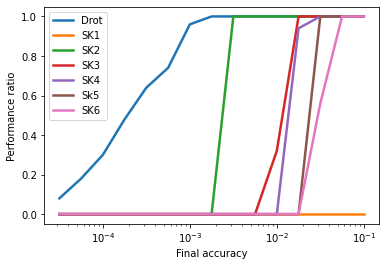

In [15]:
labels = ['Drot', 'SK1', 'SK2', 'SK3', 'SK4', 'Sk5', 'SK6']
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
dir = "output/" + file_name  + '.npy'
fig = profile(dir, accuracies, labels, colors)

# fig.savefig('Figures/'+ file_name + '.eps', format='eps')

## Single problem

In [62]:

m, n, C, p, q = two_dimensional_gaussian_ot(32, 32)
C_ = C.copy()
G0 = ot.emd(p, q, C_, numItermax=1_000_000)
Gsk = ot.sinkhorn(p, q, C_, 1e-3, numItermax=1000, stopThr=1e-5)
Gsb = ot.bregman.sinkhorn_stabilized(p, q, C_, 1e-3, umItermax=1000, stopThr=1e-5)

Drot terminated at iteration  999


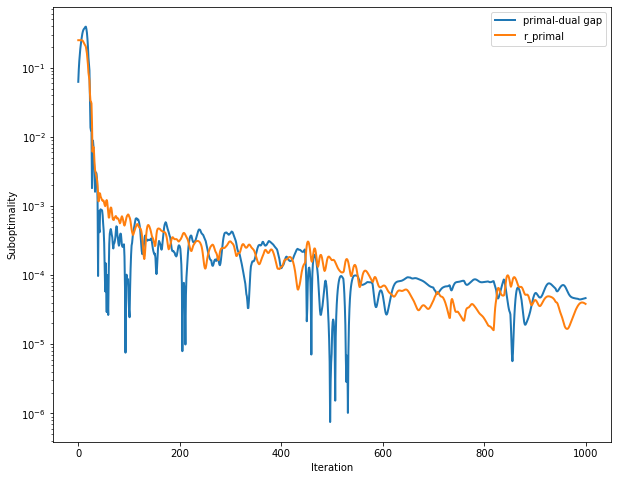

In [67]:
x0 = np.array(np.outer(p, q), order = 'F')
max_iters = 1000
step = 2 / (m+n)

drout  = drot(x0, C, p, q, max_iters=max_iters, step=step, compute_r_primal=True, 
              compute_r_dual=True, adapt_stepsize=False, max_step=20*step, min_step=step/100,
              eps_abs=1e-5, eps_rel=0, verbose=False, print_every=100)
xopt = drout["sol"]

plt.figure(1, figsize=(10,8))

plt.plot(range(drout["num_iters"]), [ f for f in drout['dual']], label='primal-dual gap', linewidth=2)
plt.plot(range(drout["num_iters"]), [r for r in drout['primal']], label='r_primal', linewidth=2)
plt.xlabel("Iteration") 
plt.ylabel("Suboptimality") 
plt.yscale('log')
plt.legend()

### Relative objective values compared to the true optimal value

In [68]:
fdr, femd, fsk, fsb = np.sum(xopt*C), np.sum(G0*C_), np.sum(Gsk*C_), np.sum(Gsb*C_)
(fdr-femd) / femd, (fsk-femd) / femd, (fsb-femd) / femd

(0.00014104183719028726, 0.0009090956906409068, 0.0009097030257273259)

### Sparsity of the approximate solutions

In [69]:
np.sum(xopt > 0), np.sum(G0 > 0), np.sum(Gsk > 0), np.sum(Gsb > 0)

(100, 32, 925, 1024)

Text(0.5, 1.0, 'OT matrix Sinkhorn')

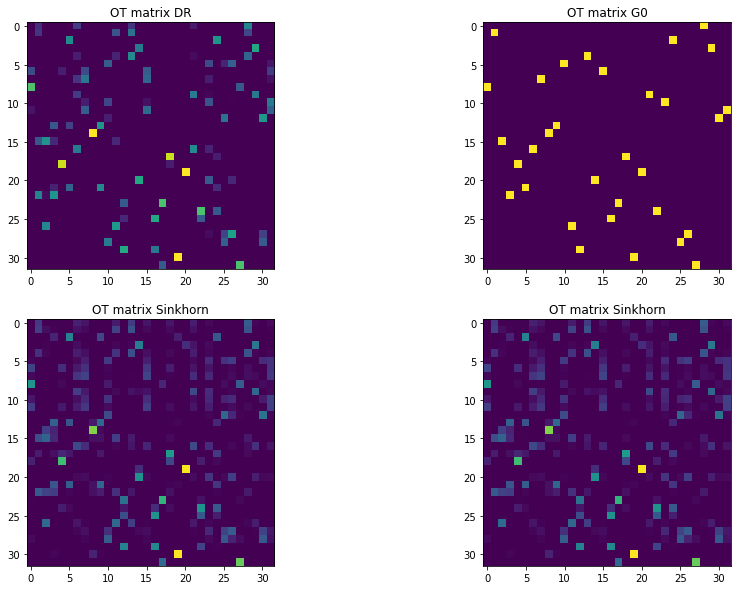

In [70]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].imshow(xopt, interpolation='nearest')
axs[0, 0].set_title('OT matrix DR')

axs[0, 1].imshow(G0, interpolation='nearest')
axs[0, 1].set_title('OT matrix G0')

axs[1, 0].imshow(Gsk, interpolation='nearest')
axs[1, 0].set_title('OT matrix Sinkhorn')

axs[1, 1].imshow(Gsk, interpolation='nearest')
axs[1, 1].set_title('OT matrix Sinkhorn')